<h1 style="color:rgb(0,120,170)">Neural Networks and Deep Learning</h1>
<h2 style="color:rgb(0,120,170)"> Predictive Analysis - Image Processing</h2>


#### Classify handwritten digits using the famous MNIST data

The goal in this task is to take an image of a handwritten single digit, and determine what that digit is.  

The data for this competition were taken from the MNIST dataset. The MNIST ("Modified National Institute of Standards and Technology") dataset is a classic within the Machine Learning community that has been extensively studied.  More detail about the dataset, including Machine Learning algorithms that have been tried on it and their levels of success, can be found at http://yann.lecun.com/exdb/mnist/index.html.  

In [1]:
import os
import sys
import time
import glob
import math
import random
import pickle
import pylab
from zipfile import ZipFile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.font_manager import FontProperties
from matplotlib import pyplot

from sklearn.model_selection import KFold
from sklearn import model_selection
from sklearn.decomposition import PCA

import tensorflow as tf

%matplotlib inline
#matplotlib.rcdefaults()
#matplotlib.verbose.set_level('silent')
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

from IPython.display import Image
from IPython.core.display import HTML

In [2]:
print(tf.__version__)

2.3.1


In [3]:
datapath = "../../../data/"
outputs = "../../../data/"

In [4]:
# read training data from CSV file 

with ZipFile(os.path.join(datapath, 'kaggle_digits_train.zip'), 'r') as myzip:
    with myzip.open('kaggle_digits_train.csv') as myfile:
        train_data = pd.read_csv(myfile)
        
with ZipFile(os.path.join(datapath, 'kaggle_digits_test.zip'), 'r') as myzip:
    with myzip.open('kaggle_digits_test.csv') as myfile:
        test_data = pd.read_csv(myfile)

print('data({0[0]},{0[1]})'.format(train_data.shape))
train_data.head()

data(42000,785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Every image is a "stretched" array of pixel values.  
In this case it's 784 pixels => 28 * 28 px  

In [5]:
images = train_data.iloc[:,1:].values
images = images.astype(np.float)

# convert from [0:255] => [0.0:1.0]
images = np.multiply(images, 1.0 / 255.0)

print('images numpy array have shape: ({0[0]},{0[1]})'.format(images.shape))

images numpy array have shape: (42000,784)


In [6]:
images

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [7]:
image_size = images.shape[1]
print ('image_size => {0}'.format(image_size))

# in this case all images are square
image_width = image_height = np.ceil(np.sqrt(image_size)).astype(np.uint8)

print ('image_width => {0}\nimage_height => {1}'.format(image_width,image_height))

image_size => 784
image_width => 28
image_height => 28


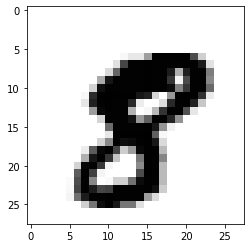

In [8]:
IMAGE_TO_DISPLAY = 10

# (784) => (28,28)
plt.imshow(images[IMAGE_TO_DISPLAY].reshape((28, 28)), cmap=cm.binary)

In [9]:
labels_flat = train_data.iloc[:,0].values

print('labels_flat({0})'.format(len(labels_flat)))
print ('labels_flat[{0}] => {1}'.format(IMAGE_TO_DISPLAY,labels_flat[IMAGE_TO_DISPLAY]))

labels_flat(42000)
labels_flat[10] => 8


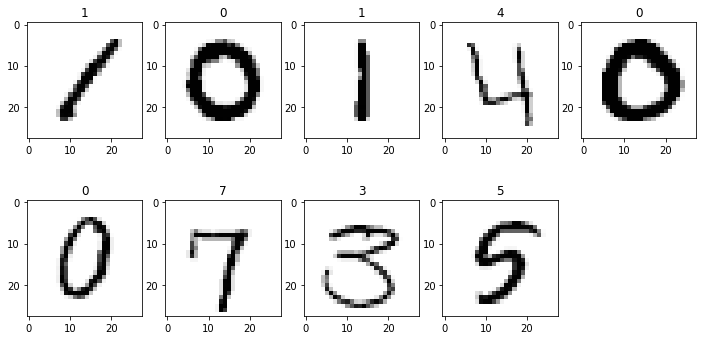

In [10]:
plt.figure(figsize=(12,6))
for i in range(0,9):
    plt.subplot(250 + (i+1))
    img = images[i,:].reshape(28, 28)
    plt.imshow(img, cmap='Greys')
    plt.title(labels_flat[i])

In [11]:
labels_count = np.unique(labels_flat).shape[0]

print('labels_count => {0}'.format(labels_count))

labels_count => 10


In [12]:
test_data.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
test_images = test_data.values.astype(np.float)
test_images.shape

(28000, 784)

In [14]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(images, 
                                                                    labels_flat, 
                                                                    test_size=0.4, 
                                                                    random_state=0)
print('train images({0[0]},{0[1]})'.format(X_train.shape))
print('validation images({0[0]},{0[1]})'.format(X_test.shape))
print('train labels({})'.format(y_train.shape))
print('validation labels({})'.format(y_test.shape))

train images(25200,784)
validation images(16800,784)
train labels((25200,))
validation labels((16800,))


In [15]:
from sklearn.ensemble import RandomForestClassifier

# create and train the random forest
# multi-core CPUs can use: rf = RandomForestClassifier(n_estimators=100, n_jobs=2)
clf_rf = RandomForestClassifier(n_estimators=300, 
                                criterion='gini', 
                                max_depth=None, 
                                min_samples_split=3, 
                                min_samples_leaf=1, 
                                min_weight_fraction_leaf=0.0, 
                                max_features='auto', 
                                max_leaf_nodes=None, 
                                bootstrap=True, 
                                oob_score=False, 
                                n_jobs=-1, 
                                random_state=0, 
                                verbose=0, 
                                warm_start=False, 
                                class_weight=None).fit(X_train, y_train)

eval_rf = clf_rf.score(X_test, y_test)
print(eval_rf)

0.9611904761904762


In [16]:
# Train SVM...
from sklearn import svm
#http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

clf_svm = svm.SVC(kernel='poly',
                  C=1.57,
                  degree=2, 
                  gamma=0.278,
                  coef0=0.0, 
                  shrinking=True, 
                  probability=False, 
                  tol=0.001, 
                  cache_size=200, 
                  class_weight=None, 
                  verbose=False, 
                  max_iter=-1, 
                  random_state=0).fit(X_train, y_train)

eval_svm = clf_svm.score(X_test, y_test)
print(eval_svm)

0.9720833333333333


Making Predictions

In [17]:
predict_rf = clf_rf.predict(test_images)
predict_rf[0:10]

array([2, 0, 9, 9, 3, 7, 0, 3, 0, 3])

In [18]:
predict_svm = clf_svm.predict(test_images)
predict_svm[0:10]

array([2, 0, 9, 0, 3, 7, 0, 3, 0, 3])

### Using Tensor Flow (with a fully connected ANN)

In [19]:
import tensorflow as tf
print(tf.__version__)

mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

2.3.1


Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


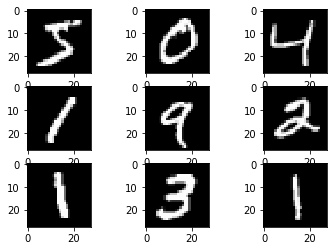

In [20]:
# summarize loaded dataset
print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))
# plot first few images
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
# show the figure
plt.show()

In [21]:
model = tf.keras.models.Sequential([tf.keras.layers.Flatten(input_shape=(28, 28)),
                                    tf.keras.layers.Dense(128, activation='relu'),
                                    tf.keras.layers.Dropout(0.2),
                                    tf.keras.layers.Dense(10, activation='softmax')
                                   ])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [22]:
%time model.fit(x_train, y_train, epochs=10)
model.evaluate(x_test,  y_test, verbose=1)

Epoch 1/10
1875/1875 [==============================] - 2s 892us/step - loss: 0.2930 - accuracy: 0.9150
Epoch 2/10
1875/1875 [==============================] - 2s 875us/step - loss: 0.1455 - accuracy: 0.9571
Epoch 3/10
1875/1875 [==============================] - 2s 905us/step - loss: 0.1082 - accuracy: 0.9672
Epoch 4/10
1875/1875 [==============================] - 2s 864us/step - loss: 0.0891 - accuracy: 0.9728
Epoch 5/10
1875/1875 [==============================] - 2s 855us/step - loss: 0.0750 - accuracy: 0.9771
Epoch 6/10
1875/1875 [==============================] - 2s 841us/step - loss: 0.0661 - accuracy: 0.9786
Epoch 7/10
1875/1875 [==============================] - 2s 849us/step - loss: 0.0588 - accuracy: 0.9806
Epoch 8/10
1875/1875 [==============================] - 1s 720us/step - loss: 0.0533 - accuracy: 0.9827
Epoch 9/10
1875/1875 [==============================] - 1s 800us/step - loss: 0.0484 - accuracy: 0.9841
Epoch 10/10
1875/1875 [==============================] - 2s 821u

[0.06762448698282242, 0.9793999791145325]

### Using Tensor Flow (with a CNN)

### a) simple model

In [23]:
def prep_pixels(train, test):
    # convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    # normalize to range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    # return normalized images
    return train_norm, test_norm

# baseline cnn model for mnist

(trainX, trainY), (testX, testY) = mnist.load_data()
# reshape dataset to have a single channel
trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
testX = testX.reshape((testX.shape[0], 28, 28, 1))
# one hot encode target values
trainY = tf.keras.utils.to_categorical(trainY)
testY = tf.keras.utils.to_categorical(testY)
# scale pixels
trainX, testX = prep_pixels(trainX, testX)



model = tf.keras.models.Sequential([tf.keras.layers.Conv2D(32, 
                                                           kernel_size=(3, 3), 
                                                           activation='relu', 
                                                           kernel_initializer='he_uniform', 
                                                           input_shape=(28, 28, 1)),
                                    tf.keras.layers.MaxPooling2D((2, 2)),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(100, activation='relu', kernel_initializer='he_uniform'),
                                    tf.keras.layers.Dense(10, activation='softmax'),
                                   ])

model.compile(optimizer='adam', #SGD(lr=0.01, momentum=0.9)
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               540900    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1010      
Total params: 542,230
Trainable params: 542,230
Non-trainable params: 0
_________________________________________________________________


In [24]:
%time model.fit(trainX, trainY, epochs=10)
model.evaluate(testX, testY, verbose=1)

Epoch 1/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.1511 - accuracy: 0.9542
Epoch 2/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0535 - accuracy: 0.9838
Epoch 3/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0321 - accuracy: 0.9901
Epoch 4/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0213 - accuracy: 0.9931
Epoch 5/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0142 - accuracy: 0.9953
Epoch 6/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0110 - accuracy: 0.9965
Epoch 7/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0094 - accuracy: 0.9969
Epoch 8/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0062 - accuracy: 0.9980
Epoch 9/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0069 - accuracy: 0.9975
Epoch 10/10
1875/1875 [==============================] - 9s 5ms/step - loss: 

[0.06818710267543793, 0.984499990940094]

### b) slightly bigger model

In [25]:
from tensorflow.keras.callbacks import EarlyStopping

In [26]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(32, 
                                 kernel_size=(3, 3),
                                 activation='relu',
                                 kernel_initializer='he_uniform',
                                 input_shape=(28, 28, 1)
                                ))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

model.compile(optimizer='adam', #tf.keras.optimizers.SGD(lr=0.01, momentum=0.9)
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)              

In [27]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

%time history = model.fit(trainX, trainY,batch_size=32, epochs=10, verbose=1, \
                          validation_data=(testX, testY), callbacks=[early_stopping])
model.evaluate(testX, testY, verbose=1)

Epoch 1/10
1875/1875 [==============================] - 34s 18ms/step - loss: 0.1948 - accuracy: 0.9413 - val_loss: 0.0602 - val_accuracy: 0.9803
Epoch 2/10
1875/1875 [==============================] - 33s 18ms/step - loss: 0.0893 - accuracy: 0.9738 - val_loss: 0.0367 - val_accuracy: 0.9879
Epoch 3/10
1875/1875 [==============================] - 33s 17ms/step - loss: 0.0659 - accuracy: 0.9801 - val_loss: 0.0285 - val_accuracy: 0.9910
Epoch 4/10
1875/1875 [==============================] - 33s 18ms/step - loss: 0.0526 - accuracy: 0.9836 - val_loss: 0.0284 - val_accuracy: 0.9911
Epoch 5/10
1875/1875 [==============================] - 33s 18ms/step - loss: 0.0468 - accuracy: 0.9855 - val_loss: 0.0320 - val_accuracy: 0.9911
Epoch 6/10
1875/1875 [==============================] - 34s 18ms/step - loss: 0.0380 - accuracy: 0.9880 - val_loss: 0.0263 - val_accuracy: 0.9917
Epoch 7/10
1875/1875 [==============================] - 34s 18ms/step - loss: 0.0341 - accuracy: 0.9890 - val_loss: 0.0278 -

[0.029262786731123924, 0.9919999837875366]

In [28]:
score = model.evaluate(testX, testY, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 1s 4ms/step - loss: 0.0293 - accuracy: 0.9920
Test loss: 0.029262786731123924
Test accuracy: 0.9919999837875366


In [29]:
hist_df = pd.DataFrame(history.history)
hist_df.head()

,loss,accuracy,val_loss,val_accuracy
0,0.194844,0.941350,0.060169,0.9803
1,0.089341,0.973783,0.036707,0.9879
2,0.065889,0.980100,0.028492,0.9910
3,0.052618,0.983600,0.028370,0.9911
4,0.046771,0.985533,0.031957,0.9911


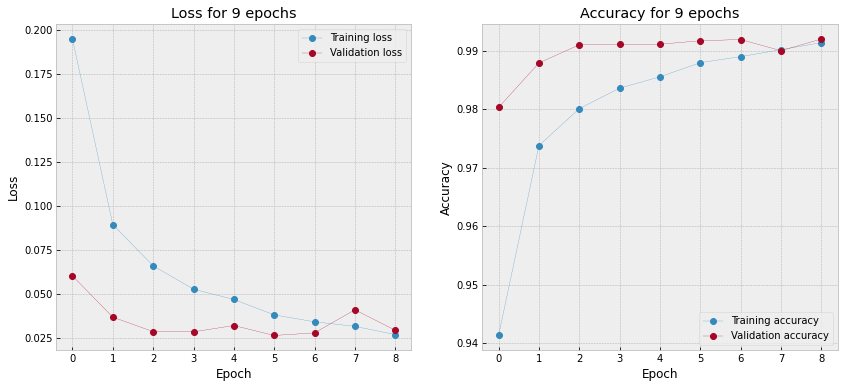

In [30]:
fig = plt.figure(figsize=(14,6))
plt.style.use('bmh')
params_dict = dict(linestyle='solid', linewidth=0.25, marker='o', markersize=6)

plt.subplot(121)
plt.plot(hist_df.loss, label='Training loss', **params_dict)
plt.plot(hist_df.val_loss, label='Validation loss', **params_dict)
plt.title('Loss for ' + str(len(history.epoch)) + ' epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(hist_df.accuracy, label='Training accuracy', **params_dict)
plt.plot(hist_df.val_accuracy, label='Validation accuracy', **params_dict)
plt.title('Accuracy for ' + str(len(history.epoch)) + ' epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

### c) Testing a more complex model

![](https://sihamtabik.github.io/LeNet-like-CNN.jpg)

In [31]:
nb_filters_1 = 32 # 64
nb_filters_2 = 64 # 128
nb_filters_3 = 128 # 256
nb_conv = 3

model = tf.keras.Sequential()
model.add(tf.keras.layers.ZeroPadding2D((1,1), input_shape=(28, 28, 1),))
model.add(tf.keras.layers.Conv2D(nb_filters_1, (nb_conv, nb_conv),  activation="relu"))
model.add(tf.keras.layers.ZeroPadding2D((1, 1)))
model.add(tf.keras.layers.Conv2D(nb_filters_1, (nb_conv, nb_conv), activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(strides=(2,2)))
model.add(tf.keras.layers.ZeroPadding2D((1, 1)))
model.add(tf.keras.layers.Conv2D(nb_filters_2, (nb_conv, nb_conv), activation="relu"))
model.add(tf.keras.layers.ZeroPadding2D((1, 1)))
model.add(tf.keras.layers.Conv2D(nb_filters_2, (nb_conv, nb_conv), activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(strides=(2,2)))
model.add(tf.keras.layers.ZeroPadding2D((1, 1)))
model.add(tf.keras.layers.Conv2D(nb_filters_3, (nb_conv, nb_conv), activation="relu"))
model.add(tf.keras.layers.ZeroPadding2D((1, 1)))
model.add(tf.keras.layers.Conv2D(nb_filters_3, (nb_conv, nb_conv), activation="relu"))
model.add(tf.keras.layers.ZeroPadding2D((1, 1)))
model.add(tf.keras.layers.Conv2D(nb_filters_3, (nb_conv, nb_conv), activation="relu"))
model.add(tf.keras.layers.ZeroPadding2D((1, 1)))
model.add(tf.keras.layers.Conv2D(nb_filters_3, (nb_conv, nb_conv), activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(strides=(2,2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(128, activation="relu"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

model.summary()

model.compile(optimizer='adam', #tf.keras.optimizers.SGD(lr=0.01, momentum=0.9)
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 30, 30, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 64)       

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

%time history = model.fit(trainX, trainY, batch_size=32, epochs=10, verbose=1, \
                          validation_data=(testX, testY), callbacks=[early_stopping])
model.evaluate(testX, testY, verbose=1)

Epoch 1/10
1875/1875 [==============================] - 80s 42ms/step - loss: 0.1479 - accuracy: 0.9530 - val_loss: 0.0472 - val_accuracy: 0.9853
Epoch 2/10
1875/1875 [==============================] - 79s 42ms/step - loss: 0.0545 - accuracy: 0.9840 - val_loss: 0.0363 - val_accuracy: 0.9882
Epoch 3/10
1759/1875 [===========================>..] - ETA: 4s - loss: 0.0389 - accuracy: 0.9883

In [ ]:
score = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
fig = plt.figure(figsize=(14,6))
plt.style.use('bmh')
params_dict = dict(linestyle='solid', linewidth=0.25, marker='o', markersize=6)

plt.subplot(121)
plt.plot(hist_df.loss, label='Training loss', **params_dict)
plt.plot(hist_df.val_loss, label='Validation loss', **params_dict)
plt.title('Loss for ' + str(len(history.epoch)) + ' epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(hist_df.accuracy, label='Training accuracy', **params_dict)
plt.plot(hist_df.val_accuracy, label='Validation accuracy', **params_dict)
plt.title('Accuracy for ' + str(len(history.epoch)) + ' epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

#### [Using the LENET architecture](https://www.pyimagesearch.com/2016/08/01/lenet-convolutional-neural-network-in-python/  )

The LeNet architecture was first introduced by LeCun et al. in their 1998 paper, Gradient-Based Learning Applied to Document Recognition. As the name of the paper suggests, the authors’ implementation of LeNet was used primarily for OCR and character recognition in documents.  

The LeNet architecture is straightforward and small, (in terms of memory footprint), making it perfect for teaching the basics of CNNs — it can even run on the CPU (if your system does not have a suitable GPU), making it a great “first CNN”.  

However, if you do have GPU support and can access your GPU via Keras, you will enjoy extremely fast training times (in the order of 3-10 seconds per epoch, depending on your GPU).  

In [ ]:
display(Image(os.path.join('../datasets/','Figs', 'lenet_architecture-768x226.png'), width=1000))

In [ ]:
class LeNet:
    @staticmethod
    def build(width, height, depth, classes, weightsPath=None):
        # initialize the model
        model = Sequential()
        # first set of CONV => RELU => POOL
        model.add(tf.keras.layers.ZeroPadding2D((1,1), input_shape=input_shape,))
        model.add(tf.keras.layers.Conv2D(20, (5, 5), padding="same", input_shape=(depth, height, width)))
        model.add(tf.keras.layers.Activation("relu"))
        model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        # second set of CONV => RELU => POOL
        model.add(tf.keras.layers.Conv2D(50, (5, 5), padding="same"))
        model.add(tf.keras.layers.Activation("relu"))
        model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        # set of FC => RELU layers
        model.add(tf.keras.layers.Flatten())
        model.add(tf.keras.layers.Dense(500))
        model.add(tf.keras.layers.Activation("relu"))
        # softmax classifier
        model.add(tf.keras.layers.Dense(classes))
        model.add(tf.keras.layers.Activation("softmax"))
        # if a weights path is supplied (inicating that the model was
        # pre-trained), then load the weights
        if weightsPath is not None:
            model.load_weights(weightsPath)
        # return the constructed network architecture
        return model

In [ ]:
# initialize the optimizer and model
print("[INFO] compiling model...")
model = LeNet.build(width=img_rows, 
                    height=img_cols, 
                    depth=1, 
                    classes=10,
                    #weightsPath=args["weights"] if args["load_model"] > 0 else None
                   )

model.summary()

model.compile(optimizer='adam', #tf.keras.optimizers.SGD(lr=0.01, momentum=0.9)
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

%time history = model.fit(trainX, trainY, batch_size=32, epochs=10, verbose=1, \
                          validation_data=(testX, testY), callbacks=[early_stopping])
model.evaluate(testX, testY, verbose=1)

In [ ]:
# show the accuracy on the testing set
print("[INFO] evaluating...")
(loss, accuracy) = model.evaluate(testX, testY, verbose=1)
print("[INFO] accuracy: {:.2f}%".format(accuracy * 100))

In [ ]:
fig = plt.figure(figsize=(14,6))
plt.style.use('bmh')
params_dict = dict(linestyle='solid', linewidth=0.25, marker='o', markersize=6)

plt.subplot(121)
plt.plot(hist_df.loss, label='Training loss', **params_dict)
plt.plot(hist_df.val_loss, label='Validation loss', **params_dict)
plt.title('Loss for ' + str(len(history.epoch)) + ' epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(hist_df.accuracy, label='Training accuracy', **params_dict)
plt.plot(hist_df.val_accuracy, label='Validation accuracy', **params_dict)
plt.title('Accuracy for ' + str(len(history.epoch)) + ' epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

#### Pre-trained models  

How can I use pre-trained models in Keras?  
Code and pre-trained weights are available for the following image classification models:  
+ Xception  
+ VGG16  
+ VGG19  
+ ResNet50  
+ Inception v3  

They can be imported from the module [keras.applications](https://keras.io/applications/):

In [ ]:
#from keras.applications.xception import Xception
#from keras.applications.vgg16 import VGG16
#from keras.applications.vgg19 import VGG19
#from keras.applications.resnet50 import ResNet50
#from keras.applications.inception_v3 import InceptionV3

#model = VGG16(weights='imagenet', include_top=True)

[Transfer Learning and Fine-Tuning](https://keras.io/guides/transfer_learning/)
[Visualizing the classification task:](http://scs.ryerson.ca/~aharley/vis/fc/)